In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

## 1. 准备数据

### 1.1)数据集读入

In [2]:
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

### 1.2)数据集乱序

In [3]:
np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

### 1.3)数据集分为训练集和测试集

In [4]:
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

### ps.转换数据类型(防止后面矩阵乘法出现错误)

In [5]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

### 1.4)配成[输入特征, 标签]对，每次喂入一小撮(batch)

In [6]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 2. 搭建网络

### 定义神经网络中所有可训练的参数

In [7]:
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

## 3. 参数优化/训练结果

### 3.1)定义参数

In [8]:
lr = 0.1
train_loss_results = []
test_acc = []
epoch = 500
loss_all = 0

### 3.2)训练和测试

In [9]:
# 训练部分
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")

Epoch 0, loss: 0.2821310982108116
Test_acc: 0.16666666666666666
--------------------------
Epoch 1, loss: 0.25459613651037216
Test_acc: 0.16666666666666666
--------------------------
Epoch 2, loss: 0.22570249810814857
Test_acc: 0.16666666666666666
--------------------------
Epoch 3, loss: 0.21028399839997292
Test_acc: 0.16666666666666666
--------------------------
Epoch 4, loss: 0.19942265003919601
Test_acc: 0.16666666666666666
--------------------------
Epoch 5, loss: 0.18873638659715652
Test_acc: 0.5
--------------------------
Epoch 6, loss: 0.17851299047470093
Test_acc: 0.5333333333333333
--------------------------
Epoch 7, loss: 0.16922876238822937
Test_acc: 0.5333333333333333
--------------------------
Epoch 8, loss: 0.16107673570513725
Test_acc: 0.5333333333333333
--------------------------
Epoch 9, loss: 0.15404685214161873
Test_acc: 0.5333333333333333
--------------------------
Epoch 10, loss: 0.14802726358175278
Test_acc: 0.5333333333333333
--------------------------
Epoch 11,

## 4. acc / loss可视化

### 4.1)绘制loss曲线

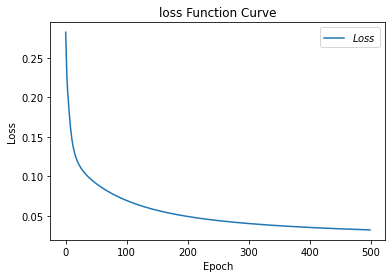

In [10]:
plt.title('loss Function Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_results, label="$Loss$")
plt.legend()

### 4.2)绘制Accuracy曲线

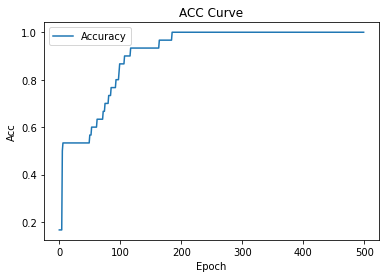

In [11]:
plt.title('ACC Curve')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.plot(test_acc, label="Accuracy")
plt.legend()